In [1]:
from PIL import Image
import torch
from torchvision.transforms import ToTensor
import torchvision.transforms as T
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
classes = ['Dog','Cat']

In [5]:
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
image_size = 84

In [23]:
test_transformer = T.Compose([T.Resize((224,224)),  # resizing all images into 250*250 pixels 
                        T.ToTensor()])

In [7]:
def conv_block(in_channels, out_channels, pool=False, dropout = False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    if dropout: layers.append(nn.Dropout2d(0.25))

    return nn.Sequential(*layers)

In [6]:
def denormalize_the_images(image, mean, std):
    if (len(image.shape) == 3):
        image = image.unsqueeze(0)
    mean = torch.tensor(mean).reshape(1,3,1,1) # image ta matrix tensor ma xa. so matrix multiply ra add garda shape eutai huna paryo nita
    std = torch.tensor(std).reshape(1,3,1,1)
    return image * std + mean

In [7]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    correct_outcomes = torch.sum(preds == labels).item()
    total_outcomes = len(labels)

    accuracy = torch.tensor(correct_outcomes / total_outcomes)
    return round((accuracy.item() * 100),3)

In [14]:
class CatDogClassifier(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.tensor(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.tensor(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))     
    

In [15]:
def conv_block(in_channels, out_channels, pool=False, dropout = False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    if dropout: layers.append(nn.Dropout2d(0.25))

    return nn.Sequential(*layers)

In [16]:
"""
This is a ResNet17 Convolutional Neural Network that I created from scratch
"""

class ResNet17(CatDogClassifier):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        # 1st convolutional layer that takes in image with size 224 * 224
        # 3 * 224 * 224
        self.conv1 = conv_block(in_channels, 4)
        # 4 * 224 * 224
        self.conv2 = conv_block(4,8)
        # 8 * 224 * 224
        self.conv3 = conv_block(8,16,pool = True)
        # 16 * 112 * 112
        self.residual_block1 = nn.Sequential(conv_block(16, 32, dropout = True),conv_block(32,16)) # conv layer 4
        # 16 * 112 * 112
        self.conv6 = conv_block(16,32, pool = True)
        # 32 * 56 * 56 
        self.residual_block2 = nn.Sequential(conv_block(32, 64, pool = False, dropout = False), conv_block(64,32))
        # 32 * 56 * 56
        self.conv9 = conv_block(32,64, pool = True)
        # 64 * 28 * 28
        self.residual_block3 = nn.Sequential(conv_block(64,128, pool = False, dropout = True),conv_block(128,64))
        # 128 * 28 * 28 ----------------------- # 64 * 28 * 28

        # input into linear layer 1 = # 1024 * 28 * 28
        self.five_linear_layers =  nn.Sequential(nn.Flatten(), 
                                           # 1st linear layer
                                           nn.Linear(64*28*28, 64),
                                           #nn.BatchNorm2d(64),
                                           nn.ReLU(inplace = True),
                                           nn.Dropout2d(0.2),                                           

                                           # 2nd linear layer
                                           nn.Linear(64,32),
                                           #nn.BatchNorm2d(32),
                                           nn.ReLU(inplace = True),
                                           nn.Dropout2d(0.2),

                                           # 3rd Linear Layer
                                           nn.Linear(32,16),
                                           #nn.BatchNorm2d(16),
                                           nn.ReLU(inplace = True),
                                           nn.Dropout2d(0.2),

                                           # 4th linear layer
                                           nn.Linear(16,8),
                                           #nn.BatchNorm2d(8),
                                           nn.ReLU(inplace = True),
                                           nn.Dropout2d(0.2),

                                           # 5th linear layer
                                           nn.Linear(8,4),
                                           #nn.BatchNorm2d(4),
                                           nn.ReLU(inplace = True),
                                           nn.Dropout2d(0.2),
                                           )
        self.classifier = nn.Linear(4,num_classes)
        
        
    def forward(self, xb):
      out = self.conv1(xb)
      out = self.conv2(out)
      out = self.conv3(out)
      out = self.residual_block1(out) + out
      out = self.conv6(out)
      out = self.residual_block2(out) + out
      out = self.conv9(out)
      out = self.residual_block3(out) + out
      out = self.five_linear_layers(out)
      out = self.classifier(out)
      return out

In [17]:
model = ResNet17(3,2)
model

ResNet17(
  (conv1): Sequential(
    (0): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv3): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (residual_block1): Sequential(
    (0): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    

In [18]:
model.load_state_dict(torch.load('catvdog-stage1-valacc-88percent.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [19]:
def predict_image(img, model,original_image):
    # Convert to a batch of 1
    # xb = to_device(img.unsqueeze(0), device)
    xb = (img.unsqueeze(0))
    # Get predictions from model
    yb = model.forward(xb)

    # Applying Softmax Function 
    yb  = F.softmax(yb, dim=1)

    # Pick index with highest probability
    prob, preds  = torch.max(yb, dim=1)

    # Retrieve the class label
    #print(preds)
    print("Probability: ",prob.item(),", Prediction: ",classes[preds.item()])
    return original_image
    #plt.imshow(denormalize_the_images(img, *imagenet_stats)[0].permute(1,2,0))

In [20]:
def open_image(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

Probability:  0.7753760814666748 , Prediction:  Dog


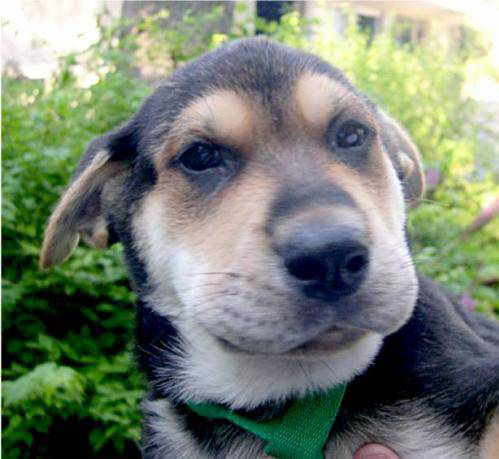

In [32]:
img = open_image("18.jpg")
predict_image(test_transformer(img), model,img)